# Prices Predictions

In [1]:
#Libraries and tools
import pandas as pd
import numpy as np
import re
import openpyxl


pd.set_option('display.max_columns', None)

In [2]:
#Define the file name and create dict to store the data from the tabs
file = 'DMN Report 29.xlsx'

In [3]:
#Reading the excel file. It is saved in a dictionary by default.
data = pd.read_excel(file, sheet_name=None)
#columns = ['WEEK', 'LACTOSE', 'CENTRAL', 'WEST', 'N EAST',	'Whey Avg',	'Whey Avg']
#columns = ['WEEK', 'LACTOSE', 'CENTRAL', 'WEST', 'N EAST',	'Whey Avg',	'Whey Avg']
columns = ['WEEK', 'LACTOSE', 'CENTRAL']

#Get the names of the tabs in the excel file
sheet_names = data.keys()
sheet_names

dict_keys(['2023', '2022', '2021', '2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012', '2010 - 2011', '2009', '2008', '2007', '2006', '2005', '2004', '2003', '2002', '2001', '2000', '1999', '1998', '1997', '1996'])

In [4]:
# Creating the preprocessing function to clean the data.
def preprocessing(df_temp):

    #Select the columns of week and lactose
    df_temp = df_temp.iloc[4:,0:3]
    df_temp.columns = columns
    
    #Deleting the Avg row
    df_temp = df_temp[df_temp['WEEK'] != 'AVG.']

    #Deleting the blanks spaces
    df_temp = df_temp.dropna(subset=['WEEK'])
    
    # Spliting the Week column in 2 different columns
    #df_temp[['start_week', 'end_week']] = [week.split('-') for week in df_temp['WEEK']]
    
    return df_temp

In [5]:
sheets_taken = []

for data_tab in data:
    try: 
        data[data_tab] = preprocessing(data[data_tab])
        sheets_taken.append(data_tab)
    except:
        print(Exception)
        

print("Sheets updated: ", sheets_taken)

Sheets updated:  ['2023', '2022', '2021', '2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012', '2010 - 2011', '2009', '2008', '2007', '2006', '2005', '2004', '2003', '2002', '2001', '2000', '1999', '1998', '1997', '1996']


In [6]:
#Creating new dataframe to concentrate all the information
complete_data = pd.DataFrame()

#Using Concat function to concentrate the information of all the valid tabs
for sheet in sheets_taken:
    data[sheet] = pd.DataFrame(data[sheet])
    complete_data = pd.concat([complete_data, data[sheet]])

#Printing all the data
complete_data

,WEEK,LACTOSE,CENTRAL
4,1/2/23 - 1/6/23,0.4775,0.41
5,1/9/23 - 1/13/23,0.4725,0.4025
6,1/16/23 - 1/20/23,0.4675,0.3725
7,1/23/23 - 1/27/23,0.445,0.36
8,1/30/23 - 2/3/23,0.44,0.36
...,...,...,...
62,11/25-12/01,0.22,0.375
64,12/02-12/08,0.22,0.365
65,12/09-12/15,0.2225,0.355
66,12/16-12/22,0.2225,0.35


In [7]:
complete_data = complete_data.drop(['WEEK'], axis=1)
complete_data

,LACTOSE,CENTRAL
4,0.4775,0.41
5,0.4725,0.4025
6,0.4675,0.3725
7,0.445,0.36
8,0.44,0.36
...,...,...
62,0.22,0.375
64,0.22,0.365
65,0.2225,0.355
66,0.2225,0.35


In [8]:
complete_data = complete_data.dropna()

X = complete_data['LACTOSE']
Y = complete_data['CENTRAL']

In [9]:
X = [x for x in X if str(x) != 'LACTOSE']
Y = [x for x in Y if str(x) != 'CENTRAL']
Y = [x for x in Y if str(x) != 'DELAC']

#Converting to float
X = [float(item) for item in X]
Y = [float(item) for item in Y]

X = np.array(X)
Y = np.array(Y)

X = np.reshape(X, (X.shape[0], 1))
Y = np.reshape(Y, (Y.shape[0], 1))


print(type(X), X.shape)
print(type(Y), Y.shape)


n_features = 1

<class 'numpy.ndarray'> (1415, 1)
<class 'numpy.ndarray'> (1415, 1)


## Scalation of data

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X = scaler.fit_transform(X)
Y = scaler.fit_transform(Y)

print(X, Y)

[[0.3943662 ]
 [0.38873239]
 [0.38309859]
 ...
 [0.10704225]
 [0.10704225]
 [0.10704225]] [[0.41943734]
 [0.41176471]
 [0.38107417]
 ...
 [0.36317136]
 [0.35805627]
 [0.35805627]]


In [11]:
n_input = X.shape[0]
n_features = 1

print(n_input, n_features)

1415 1


## Time Series Generator

In [12]:
from keras.preprocessing.sequence import TimeseriesGenerator

generator = TimeseriesGenerator(X, X, length=n_input-1, batch_size=2)
generator

## Split data

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1132, 1) (1132, 1)
(283, 1) (283, 1)


## Model Prediction

In [14]:
#libraries to use the model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [15]:
#Model Creation
lstm_model = Sequential()

lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

2023-12-01 21:29:01.804406: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-12-01 21:29:01.804442: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-12-01 21:29:01.804453: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-12-01 21:29:01.805148: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-01 21:29:01.805489: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               161600    
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 161801 (632.04 KB)
Trainable params: 161801 (632.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
lstm_model.fit(X_train, y_train, epochs=10)

Epoch 1/10


2023-12-01 21:29:19.568981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 5s 72ms/step - loss: 0.1401
Epoch 2/10
36/36 [==============================] - 0s 10ms/step - loss: 0.0516
Epoch 3/10
36/36 [==============================] - 0s 10ms/step - loss: 0.0112
Epoch 4/10
36/36 [==============================] - 0s 10ms/step - loss: 0.0086
Epoch 5/10
36/36 [==============================] - 0s 10ms/step - loss: 0.0085
Epoch 6/10
36/36 [==============================] - 0s 10ms/step - loss: 0.0085
Epoch 7/10
36/36 [==============================] - 0s 10ms/step - loss: 0.0084
Epoch 8/10
36/36 [==============================] - 0s 10ms/step - loss: 0.0084
Epoch 9/10
36/36 [==============================] - 0s 10ms/step - loss: 0.0084
Epoch 10/10
36/36 [==============================] - 0s 10ms/step - loss: 0.0084


Text(0.5, 1.0, 'Val Loss of LSTM model')

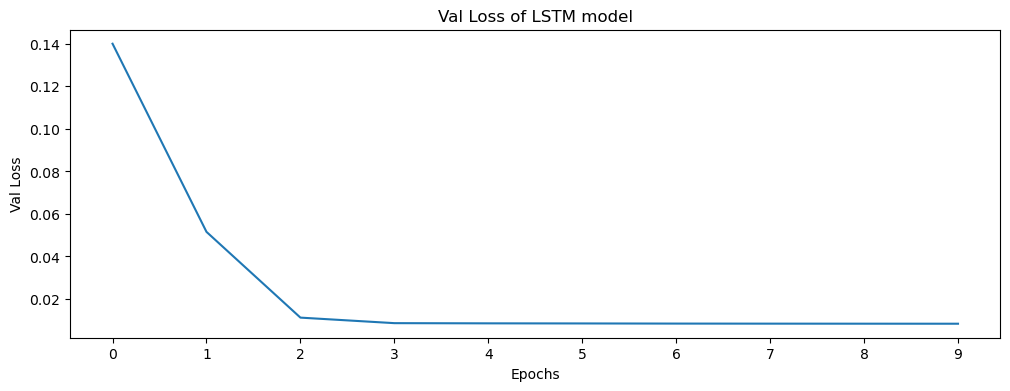

In [17]:
import matplotlib.pyplot as plt 

losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm)
plt.xlabel("Epochs")
plt.ylabel("Val Loss")
plt.title("Val Loss of LSTM model")


In [19]:
y_pred = lstm_model(X_test)

In [21]:
y_pred = scaler.inverse_transform(y_pred)
y_pred

array([[0.29921489],
       [0.70304592],
       [0.40300157],
       [0.42857349],
       [0.52021639],
       [0.60881508],
       [0.52021639],
       [0.4466374 ],
       [0.43372084],
       [0.43629866],
       [0.45507006],
       [0.53477552],
       [0.28532401],
       [0.31198436],
       [0.30832232],
       [0.31565339],
       [0.31932848],
       [0.32669707],
       [0.66393157],
       [0.32300975],
       [0.32792754],
       [0.33779563],
       [0.52021639],
       [0.4466374 ],
       [0.44404858],
       [0.28291732],
       [0.38085117],
       [0.31932848],
       [0.32915865],
       [0.33039045],
       [0.36891431],
       [0.62250468],
       [0.58164661],
       [0.42343715],
       [0.4622282 ],
       [0.38274153],
       [0.38022134],
       [0.33285617],
       [0.30588997],
       [0.31565339],
       [0.52814944],
       [0.39031853],
       [0.30103332],
       [0.51756959],
       [0.39792011],
       [0.33039045],
       [0.43114577],
       [0.381

In [23]:
#Libraries to evaluate model
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn import metrics

In [29]:
#Function to evalute the model

def evaluation_model(y_test, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print("Model evaluation: ")
    print(f'MSE es: {metrics.mean_squared_error(y_test, y_pred)}')
    print(f'MAE es: {metrics.mean_absolute_error(y_test, y_pred)}')        
    print(f'RMSE es: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}')
    print(f'MAPE es: {mean_absolute_percentage_error(y_test, y_pred)}')
    print(f'R2 es: {metrics.r2_score(y_test, y_pred)}', end='\n\n')

In [30]:
evaluation_model(y_test, y_pred)

Model evaluation: 
MSE es: 0.008141545263025905
MAE es: 0.06891899087404853
RMSE es: 0.09023051181848579
MAPE es: 18.105408381998238
R2 es: 0.6181551964581371

